# Classes

In [1]:
# Advanced Planning and Scheduling Demo

# product
class Product:
    def __init__(self, name, demand, priority, production_time, lb_time, ub_time):
        # product attributes
        self.name = name # name/label of the product
        self.demand = demand # demand of the product (quantity required by customers)
        self.min_demand_size = 0 # minimum demand size of the package
        self.priority = priority # priority of the product, higher priority products are produced first
        self.production_time = production_time # time it takes to produce the product
        self.lb_time = lb_time # lower bound time that the product should be produced before
        self.ub_time = ub_time # upper bound time that the product should be produced after
        
        # required resources
        self.required_resources = []
        
    def __str__(self):
        return self.name

#TODO: add resource classes attributes
# resource
class machine:
    def __init__(self, name, capacity, setup_time):
        # resource attributes
        self.name = name # name/label of the resource
        self.capacity = capacity # capacity of the resource
        self.setup_time = setup_time # time it takes to setup the resource
        
        self.able_to_produce = []
        
    def __str__(self):
        return self.name

class worker:
    def __init__(self, name, capacity, setup_time):
        # resource attributes
        self.name = name # name/label of the resource
        self.capacity = capacity # capacity of the resource
        self.setup_time = setup_time # time it takes to setup the resource
        
        self.able_to_produce = []
        
    def __str__(self):
        return self.name



In [2]:
# Create products
product_A = Product('A', 100, 1, 10, 0, 100)
product_B = Product('B', 200, 2, 15, 0, 100)

# Create machine
machine_x = machine('x', 1, 5)

# Create worker
worker_1 = worker('Worker 1', 1, 0)

# Assign products to machine
machine_x.able_to_produce = [product_A, product_B]

# Assign products to worker
worker_1.able_to_produce = [product_A, product_B]

# Mixed Integer Programming for Production Scheduling

### minimize the total cost( $TC$ )

$$ TC = t_c + v_c + s_c + l_c $$
- $t_c$ : sum of time cost that needed to complete all the products
- $v_c$ : sum of vialation cost tat needed
- $s_c$ : short term cost: sum of cost that needed for workers/resources.
- $l_c$ : long term cost: sum of hardware cost that needed, fixed cost.

### via the following constraints of products and workers:
- each product has a deadline, and the deadline is the time that the product should be completed.
  - $\leq$ deadline fine, otherwise violation cost.
  - total_products $\geq$ demand $-$ violations
  - violations $\leq$ allowed_violations (can also be per time period/ total)

- each worker can only work on one machine at a time:
  - $ \sum_{i=1}^{n} x_{i,j} \leq 1 $ $\forall j$ in $[1, m]$ $\textbf{Binary}$

- each machine can only work on one product at a time:
  - $ \sum_{j=1}^{m} x_{i,j} \leq 1 $ $\forall i$ in $[1, n]$ $\textbf{Binary}$

- machine change to produce a new product need a context switch time:
  - HOW TO IMPLEMENT THIS?
  - using a binary variable to indicate the context switch time?
  - $ x_{i,j} + x_{i+1,j} \leq 1 $ $\forall i$ in $[1, n-1]$, $\forall j$ in $[1, m]$ $\textbf{Binary}$ ??? TODO ???

- each worker has a maximum working time:
  - $ worker_{i} \leq max_{worker_{i}} $ $\forall i$ in $[1, n]$

### via the following constraints of supplies and demands:
- each product need enough supplies to begin with
  - $ \sum_{j=1}^{m} x_{i,j} \geq min_{batch_{i}} $ $\forall i$ in $[1, a]$
- each product/supply has cost to stay in the warehouse
  - add the cost of warehouse in short term cost
- some product has minimum size of batch to produce
  - the product need to stay in the warehouse before it can be shipped
      ####  IGNORE THIS FOR NOW
  - $\sum_{j=1}^{m} x_{i,j} \geq min_{batch_{i}}$ $\forall i$ in $[1, a]$


In [3]:
import pulp

# Define the parameters (example values)
products = [1, 2]  # List of products
workers = [1, 2]   # List of workers
machines = [1, 2]  # List of machines
time_periods = [1, 2, 3, 4]  # List of time periods

C = { (1, 1, 1, 1): 10, (1, 1, 1, 2): 12, (1, 1, 1, 3): 14, (1, 1, 1, 4): 16,
      (1, 1, 2, 1): 18, (1, 1, 2, 2): 20, (1, 1, 2, 3): 22, (1, 1, 2, 4): 24,
      # Add more cost values for other combinations
      (1, 2, 1, 1): 10, (1, 2, 1, 2): 12, (1, 2, 1, 3): 14, (1, 2, 1, 4): 16,
      (1, 2, 2, 1): 18, (1, 2, 2, 2): 20, (1, 2, 2, 3): 22, (1, 2, 2, 4): 24,
      (2, 1, 2, 4): 30, (2, 1, 2, 3): 28, (2, 1, 2, 2): 26, (2, 1, 2, 1): 24,
      (2, 1, 1, 4): 22, (2, 1, 1, 3): 20, (2, 1, 1, 2): 18, (2, 1, 1, 1): 16,
      (2, 2, 2, 4): 30, (2, 2, 2, 3): 28, (2, 2, 2, 2): 26, (2, 2, 2, 1): 24,
      (2, 2, 1, 4): 22, (2, 2, 1, 3): 20, (2, 2, 1, 2): 18, (2, 2, 1, 1): 16
    }
D = { 1: 3, 2: 4 }  # Deadlines for products
W = { 1: 2, 2: 3 }  # Maximum working times for workers
S = { 1: 1, 2: 2 }  # Context switch times for products
P = { 1: 1, 2: 2 }  # Minimum batch sizes for products
H = { 1: 5, 2: 6 }  # Storage costs per unit time
R = { 1: 1, 2: 1 }  # Supply requirements for products

# Create the problem
prob = pulp.LpProblem("Production_Scheduling", pulp.LpMinimize)

# Decision variables
x = pulp.LpVariable.dicts("x", (products, workers, machines, time_periods), cat='Binary')
y = pulp.LpVariable.dicts("y", (products, time_periods), cat='Binary')
z = pulp.LpVariable.dicts("z", (products, time_periods), cat='Binary')

# Objective function
prob += pulp.lpSum(C[i, j, k, t] * x[i][j][k][t] for i in products for j in workers for k in machines for t in time_periods) + \
        pulp.lpSum(H[i] * y[i][t] for i in products for t in time_periods)

# Constraints

# Deadline constraints
for i in products:
    prob += pulp.lpSum(x[i][j][k][t] for j in workers for k in machines for t in time_periods if t <= D[i]) >= 1

# Single machine constraint
for t in time_periods:
    for j in workers:
        prob += pulp.lpSum(x[i][j][k][t] for i in products for k in machines) <= 1

# Single product on machine constraint
for t in time_periods:
    for k in machines:
        prob += pulp.lpSum(x[i][j][k][t] for i in products for j in workers) <= 1

# Context switch constraint
for i in products:
    for t in time_periods:
        if t > 1:
            prob += pulp.lpSum(x[i][j][k][t] for j in workers for k in machines) - \
                    pulp.lpSum(x[i][j][k][t-S[i]] for j in workers for k in machines) <= 0

# Maximum working time constraint
for j in workers:
    prob += pulp.lpSum(x[i][j][k][t] for i in products for k in machines for t in time_periods) <= W[j]

# Supply availability constraint
for i in products:
    for t in time_periods:
        prob += pulp.lpSum(x[i][j][k][t] for j in workers for k in machines) <= R[i]

# Warehouse cost constraint
for i in products:
    for t in time_periods:
        prob += y[i][t] >= pulp.lpSum(x[i][j][k][t] for j in workers for k in machines)

# Minimum batch size constraint
for i in products:
    for t in time_periods:
        prob += pulp.lpSum(x[i][j][k][t] for j in workers for k in machines) >= P[i] * z[i][t]

# Solve the problem
prob.solve()

# Output the results
for v in prob.variables():
    print(f"{v.name} = {v.varValue}")

print(f"Total cost = {pulp.value(prob.objective)}")


KeyError: 0

### indices:
- $i$ : product index: ith product
- $j$ : worker index: jth worker
- $k$ : machine index: kth machine
- $l$ : supply index: lth supply (IGNORE FOR NOW)
- $t$ : time index: tth time period

### variables:
- $x_{i,j,k,t}$ : binary variable, 1 if product i is produced by worker j on machine k at time t, 0 otherwise
- $y_{i,t}$ : binary variable, 1 if product i is in the warehouse at time t, 0 otherwise

  - $s_{l,t}$ : Inventory of supply l at time t
  - $z_{i,t}$ : binary variable, 1 if product i is shipped at time t, 0 otherwise
  - $w_{j,t}$ : binary variable, 1 if worker j is working at time t, 0 otherwise
  - $m_{k,t}$ : binary variable, 1 if machine k is working at time t, 0 otherwise


## E.g.

I have two machines with 3 types of products
 <!-- and 3 workers with different working time: -->
Type A product:
  Produce a product A need 15 hours of machine A or 10 hours of machine B.
  <!-- I need 2 units of supply to start, and I have 3 units of supply in the warehouse. The cost of supply is 1.5 per unit per day.  -->
  The deadline is 5 days and I need to provide 5 product A, otherwise it will cost me 1000 units for each vialation of a day.
  <!-- The batch size is 1. -->
Type B product:
  Produce a product B need 10 hours of machine A or 7 hours of machine B.
  The deadline is 3 days and I need to provide 3 product B, otherwise it will cost me 500 units for each one vialation of a day.
Type C product:
  Produce a product C need 20 hours of machine A or 12 hours of machine B.
  The deadline is 7 days and I need to provide 7 product C, otherwise it will cost me 2000 units for each one vialation of a day.

Install the model of A need 1 hours of machine A or 1 hours of machine B.
Install the model of B need 3 hours of machine A or 2 hours of machine B.
Install the model of C need 2 hours of machine A or 2 hours of machine B.

Need coorisponding model to produce the product, and the cost of the model is 1000 per day.

What is the minimum cost to produce all the products?

## Model

### Variables
- $\text{product}_{i,j,t}$: the number of product $i$ produced by machine $j$ at time $t$ 0=not produced, 1=produced
- $\text{machine}_{j,t}$: the number of machine $j$ working at time $t$ 0=not working, 1=working
- $\text{change}_{j,t}$: the number of machine $j$ change the product at time $t$ 0=change to A, 1=change to B, 2=change to C
- $\text{not complete}_{i,t}$: the number of product $i$ produced at time $t$ and the product is not completed at time $t$
- $\text{complete}_{i,t}$: the number of product $i$ produced at time $t$ and the product is completed at time $t$
- $\text{after deadline}_{i,t}$: the number of product $i$ produced at time $t$ and the product is after the deadline at time $t$

### Objective
minimize the total cost( $TC$ )

$TC = \sum_{i,j,t} \text{product}_{i,j,t} \times \text{cost}_{i,j} + \sum_{j,t} \text{machine}_{j,t} \times \text{cost}_{j} + \sum_{j,t} \text{change}_{j,t} \times \text{cost}_{j} + \sum_{i,t} \text{not\_complete}_{i,t} \times cost_{i} + \sum_{i,t} \text{after\_deadline}_{i,t} \times \text{cost\_vialation}_{i}$

where
- $cost_{i,j}$: the cost of producing product $i$ by machine $j$
- $cost_{j}$: the cost of working machine $j$
- $cost_{i}$: the cost of not completing product $i$
- $cost_{i}$: the cost of after the deadline of product $i$

### Constraints
- $product_{i,j,t} \leq machine_{j,t}$
- $\sum_{j} product_{i,j,t} \leq 1$


In [11]:
import pulp as lp

# Initialize the problem
prob = lp.LpProblem("Production_Scheduling", lp.LpMinimize)

# Define parameters
num_machines = 2
num_products = 3
time_horizon = 7  # Assuming a maximum of 7 days for simplicity

# Production times
hours = {
    "A": {"A": 15, "B": 10},
    "B": {"A": 10, "B": 7},
    "C": {"A": 20, "B": 12}
}

# Deadlines and penalties
deadlines = {"A": 5, "B": 3, "C": 7}
quantities = {"A": 5, "B": 3, "C": 7}
penalties = {"A": 1000, "B": 500, "C": 2000}
change_cost = 1000

# Define variables
x = lp.LpVariable.dicts("x", ((i, j, t) for i in "ABC" for j in "AB" for t in range(1, time_horizon + 1)), cat="Binary")
m = lp.LpVariable.dicts("m", ((j, t) for j in "AB" for t in range(1, time_horizon + 1)), cat="Binary")
c = lp.LpVariable.dicts("c", ((j, t) for j in "AB" for t in range(2, time_horizon + 1)), cat="Binary")
n = lp.LpVariable.dicts("n", ((i, t) for i in "ABC" for t in range(deadlines[i] + 1, time_horizon + 1)), cat="Binary")
p = lp.LpVariable.dicts("p", ((i, t) for i in "ABC" for t in range(1, time_horizon + 1)), lowBound=0, cat="Continuous")

# Objective function
prob += lp.lpSum(penalties[i] * n[i, t] for i in "ABC" for t in range(deadlines[i] + 1, time_horizon + 1)) + \
        lp.lpSum(change_cost * c[j, t] for j in "AB" for t in range(2, time_horizon + 1))

# Constraints
for j in "AB":
    for t in range(1, time_horizon + 1):
        prob += lp.lpSum(hours[i][j] * x[i, j, t] for i in "ABC") <= 24 * m[j, t]

for i in "ABC":
    prob += lp.lpSum(p[i, t] for t in range(1, time_horizon + 1)) >= quantities[i]

for i in "ABC":
    for t in range(1, time_horizon + 1):
        prob += p[i, t] == lp.lpSum(x[i, j, t] for j in "AB")

for i in "ABC":
    for t in range(deadlines[i] + 1, time_horizon + 1):
        prob += n[i, t] >= quantities[i] - lp.lpSum(p[i, tau] for tau in range(1, t + 1))

for j in "AB":
    for t in range(2, time_horizon + 1):
        for i in "ABC":
            prob += c[j, t] >= x[i, j, t] - x[i, j, t - 1]

for i in "ABC":
    for j in "AB":
        for t in range(1, time_horizon + 1):
            prob += x[i, j, t] <= m[j, t]

# Solve the problem
prob.solve()

# Print the results
print("Status:", lp.LpStatus[prob.status])

# Total cost
print("Total Cost = ", lp.value(prob.objective))

# Production plan
for i in "ABC":
    for j in "AB":
        for t in range(1, time_horizon + 1):
            if lp.value(x[i, j, t]) == 1:
                print(f"Produce product {i} on machine {j} at time {t}")

# Machine working times
for j in "AB":
    for t in range(1, time_horizon + 1):
        if lp.value(m[j, t]) == 1:
            print(f"Machine {j} working at time {t}")

# Machine changes
for j in "AB":
    for t in range(2, time_horizon + 1):
        if lp.value(c[j, t]) == 1:
            print(f"Machine {j} changed product at time {t}")


Status: Optimal
Total Cost =  0.0
Produce product A on machine B at time 1
Produce product A on machine B at time 2
Produce product A on machine B at time 3
Produce product A on machine B at time 4
Produce product A on machine B at time 5
Produce product B on machine A at time 1
Produce product B on machine A at time 2
Produce product B on machine A at time 3
Produce product B on machine A at time 4
Produce product C on machine B at time 1
Produce product C on machine B at time 2
Produce product C on machine B at time 3
Produce product C on machine B at time 4
Produce product C on machine B at time 5
Produce product C on machine B at time 6
Produce product C on machine B at time 7
Machine A working at time 1
Machine A working at time 2
Machine A working at time 3
Machine A working at time 4
Machine A working at time 5
Machine A working at time 6
Machine A working at time 7
Machine B working at time 1
Machine B working at time 2
Machine B working at time 3
Machine B working at time 4
Ma

In [2]:
import pulp as lp

# Initialize the problem
prob = lp.LpProblem("Production_Scheduling", lp.LpMinimize)

# Define parameters
num_machines = 2
num_products = 3
time_horizon = 7*24  # Assuming a maximum of 7 days for simplicity

# Production times
hours = {
    "A": {"P": 15, "Q": 10},
    "B": {"P": 10, "Q": 7},
    "C": {"P": 20, "Q": 12}
}

# Deadlines and penalties
deadlines = {"A": 5*24, "B": 3*24, "C": 7*24}
quantities = {"A": 5, "B": 3, "C": 7}
penalties = {"A": 1000, "B": 500, "C": 2000}
change_cost = 1000 # Cost of changing product on a machine

# Define variables
# product i is produced by machine j at time t
x = lp.LpVariable.dicts("x", ((i, j, t) for i in "ABC" for j in "PQ" for t in range(1, time_horizon + 1)), cat="Binary")
# machine j is working at time t
m = lp.LpVariable.dicts("m", ((j, t) for j in "PQ" for t in range(1, time_horizon + 1)), cat="Binary")
# machine j changes product at time t
c = lp.LpVariable.dicts("c", ((j, t) for j in "PQ" for t in range(2, time_horizon + 1)), cat="Binary")
# product i is not produced after deadline t
n = lp.LpVariable.dicts("n", ((i, t) for i in "ABC" for t in range(deadlines[i] + 1, time_horizon + 1)), cat="Binary")
# quantity of product i produced at time t
p = lp.LpVariable.dicts("p", ((i, t) for i in "ABC" for t in range(1, time_horizon + 1)), lowBound=0, cat="Continuous")
# # total work hours of product i on machine j at time t
# w = lp.LpVariable.dicts("w", ((i, j, t) for i in "ABC" for j in "PQ" for t in range(1, time_horizon + 1)), lowBound=0, cat="Continuous")

# Objective function
prob += lp.lpSum(penalties[i] * n[i, t] for i in "ABC" for t in range(deadlines[i] + 1, time_horizon + 1)) + \
        lp.lpSum(change_cost * c[j, t] for j in "PQ" for t in range(2, time_horizon + 1))

# Constraints
        
for i in "ABC":
    for j in "PQ":
        prob += lp.lpSum(hours[i][j] * x[i, j, t] for t in range(1, time_horizon + 1)) >= quantities[i] * hours[i][j]
# total work hours of product i on machine j at time t <= 24 hours * machine working at time t
for j in "PQ":
    for t in range(1, time_horizon + 1):
        prob += lp.lpSum(hours[i][j] * x[i, j, t] for i in "ABC") <= 24 * m[j, t]

# quantity of product i produced at time t >= quantities[i]
for i in "ABC":
    prob += lp.lpSum(p[i, t] for t in range(1, time_horizon + 1)) >= quantities[i] # if not feasible, larger time horizon is needed

# quantity of product i produced at time t = sum of products produced by machine j at time t
for i in "ABC":
    for t in range(1, time_horizon + 1):
        prob += p[i, t] == lp.lpSum(x[i, j, t] for j in "PQ")

for i in "ABC":
    for t in range(deadlines[i] + 1, time_horizon + 1):
        prob += n[i, t] >= quantities[i] - lp.lpSum(p[i, tau] for tau in range(1, t + 1))

for j in "PQ":
    for t in range(2, time_horizon + 1):
        for i in "ABC":
            prob += c[j, t] >= x[i, j, t] - x[i, j, t - 1]

for i in "ABC":
    for j in "PQ":
        for t in range(1, time_horizon + 1):
            prob += x[i, j, t] <= m[j, t]
    
# each machine can only produce one product at a time        
for i in "PQ":
    for t in range(1, time_horizon + 1):
        prob += lp.lpSum(x[j, i, t] for j in "ABC") <= 1

# Solve the problem
solver = lp.PULP_CBC_CMD(msg=1, timeLimit=60)
# solver = lp.GUROBI_CMD(msg=1, timeLimit=60)
prob.solve(solver)

# Print the results
print("Status:", lp.LpStatus[prob.status])

# Total cost
print("Total Cost = ", lp.value(prob.objective))

# Production plan
for i in "ABC":
    for j in "PQ":
        for t in range(1, time_horizon + 1):
            if lp.value(x[i, j, t]) == 1:
                print(f"Produce product {i} on machine {j} at time {t}")

# # Machine working times
# for j in "PQ":
#     for t in range(1, time_horizon + 1):
#         if lp.value(m[j, t]) == 1:
#             print(f"Machine {j} working at time {t}")

# Machine changes
for j in "PQ":
    for t in range(2, time_horizon + 1):
        if lp.value(c[j, t]) == 1:
            print(f"Machine {j} changed product at time {t}")


Status: Optimal
Total Cost =  4000.0
Produce product A on machine P at time 57
Produce product A on machine P at time 58
Produce product A on machine P at time 59
Produce product A on machine P at time 60
Produce product A on machine P at time 61
Produce product A on machine P at time 62
Produce product A on machine P at time 63
Produce product A on machine P at time 64
Produce product A on machine P at time 65
Produce product A on machine P at time 66
Produce product A on machine P at time 67
Produce product A on machine P at time 68
Produce product A on machine P at time 69
Produce product A on machine P at time 70
Produce product A on machine P at time 71
Produce product A on machine Q at time 1
Produce product A on machine Q at time 2
Produce product A on machine Q at time 3
Produce product A on machine Q at time 4
Produce product A on machine Q at time 5
Produce product A on machine Q at time 6
Produce product A on machine Q at time 7
Produce product A on machine Q at time 8
Produ

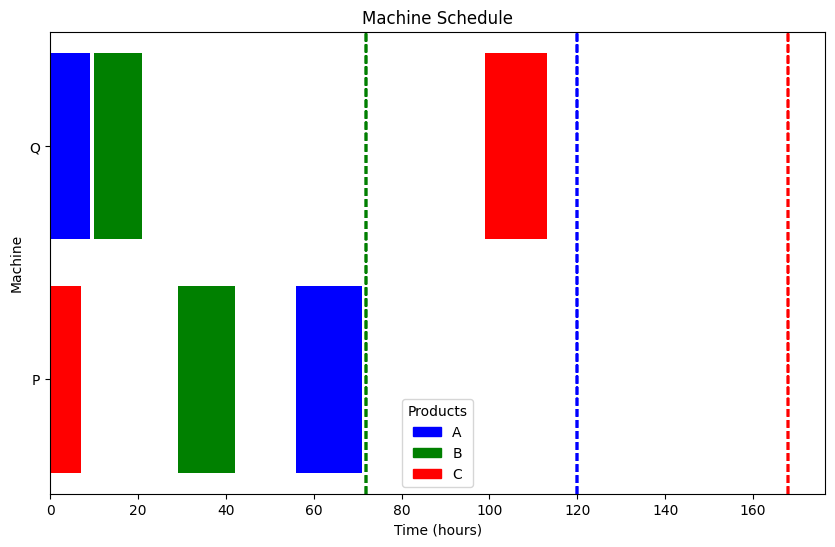

In [3]:
import matplotlib.pyplot as plt
import pandas as pd

# Extract the solution for plotting
schedule = []
for i in "ABC":
    for j in "PQ":
        for t in range(1, time_horizon + 1):
            if lp.value(x[i, j, t]) == 1:
                schedule.append((i, j, t))

# Create a DataFrame for the schedule
df = pd.DataFrame(schedule, columns=["Product", "Machine", "Time"])

# Create a Gantt chart
fig, ax = plt.subplots(figsize=(10, 6))

# Define colors for each product
colors = {"A": "blue", "B": "green", "C": "red"}

# Plot each product on each machine
for machine in df["Machine"].unique():
    machine_data = df[df["Machine"] == machine]
    for i, row in machine_data.iterrows():
        ax.barh(machine, 1, left=row["Time"]-1, color=colors[row["Product"]])

# Set labels
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Machine")
ax.set_title("Machine Schedule")

# Set y-ticks to show machine labels
ax.set_yticks(range(len(df["Machine"].unique())))
ax.set_yticklabels(df["Machine"].unique())

# Display the deadlines of each product
for i, row in df.iterrows():
    plt.axvline(x=deadlines[row["Product"]], color=colors[row["Product"]], linestyle="--")
    # plt.text(deadlines[row["Product"]], i + 0.25, f"Deadline {row['Product']}", color=colors[row["Product"]])

# Display the legend
handles = [plt.Rectangle((0,0),1,1, color=colors[product]) for product in colors]
labels = colors.keys()
ax.legend(handles, labels, title="Products")

# Show the plot
plt.show()


## Model

### Variables
- For every product $i$: $X_{i,j,t}$: binary variable, 1 if product i is introduced to machine j at time t, 0 otherwise

In [89]:
import pulp as lp
==== STOP ====
# Initialize the problem
prob = lp.LpProblem("Production_Scheduling", lp.LpMinimize)

# Define parameters
num_machines = 2
num_products = 3
time_horizon = 7*24  # Assuming a maximum of 7 days for simplicity

# Production times
hours = {
    "A": {"P": 15, "Q": 10},
    "B": {"P": 10, "Q": 7},
    "C": {"P": 20, "Q": 12}
}

hours_shift = {}
for i in "ABC":
  for j in "PQ":
    for k in range(time_horizon):
      if k - hours[i][j] >= 0:
        hours_shift.update({(i, j, k): range(k-hours[i][j], k)})
      else:
        hours_shift.update({(i, j, k): k})
print(hours_shift)
print(len(hours_shift))

# Deadlines and penalties
deadlines = {"A": 5*24, "B": 3*24, "C": 7*24}
quantities = {"A": 5, "B": 3, "C": 7}
penalties = {"A": 1000, "B": 500, "C": 2000}
change_cost = 1000 # Cost of changing product on a machine

# Define variables
# # product i start produce by machine j at time t
# start_at = lp.LpVariable.dicts("start_at", ((i, j, t) for i in "ABC" for j in "PQ" 
#                                                       for t in range(1, time_horizon + 1)),
#                                cat="Binary")
# product i is produced by machine j at time t
x = lp.LpVariable.dicts("x", ((i, j, t) for i in "ABC" for j in "PQ" for t in range(1, time_horizon + 1)), cat="Binary")
# machine j is working at time t
m = lp.LpVariable.dicts("m", ((j, t) for j in "PQ" for t in range(1, time_horizon + 1)), cat="Binary")
# machine j changes product at time t
c = lp.LpVariable.dicts("c", ((j, t) for j in "PQ" for t in range(2, time_horizon + 1)), cat="Binary")
# product i is not produced after deadline t
n = lp.LpVariable.dicts("n", ((i, t) for i in "ABC" for t in range(deadlines[i] + 1, time_horizon + 1)), cat="Binary")
# quantity of product i produced at time t
p = lp.LpVariable.dicts("p", ((i, t) for i in "ABC" for t in range(1, time_horizon + 1)), lowBound=0, cat="Continuous")
# # total work hours of product i on machine j at time t
# w = lp.LpVariable.dicts("w", ((i, j, t) for i in "ABC" for j in "PQ" for t in range(1, time_horizon + 1)), lowBound=0, cat="Continuous")
# occupancy of machine j at time t
o = lp.LpVariable.dicts("o", ((j, t) for j in "PQ" for t in range(1, time_horizon + 1)), cat="Integer", lowBound=0, upBound=1)

# Objective function
prob += lp.lpSum(penalties[i] * n[i, t] for i in "ABC" for t in range(deadlines[i] + 1, time_horizon + 1)) + \
        lp.lpSum(change_cost * c[j, t] for j in "PQ" for t in range(2, time_horizon + 1))

# Constraints
# total work hours of product i on machine j at time t <= 24 hours * machine working at time t
for j in "PQ":
    for t in range(1, time_horizon + 1):
        prob += lp.lpSum(hours[i][j] * x[i, j, t] for i in "ABC") <= 24 * m[j, t]

# quantity of product i produced at time t >= quantities[i]
for i in "ABC":
    prob += lp.lpSum(p[i, t] for t in range(1, time_horizon + 1)) >= quantities[i] # if not feasible, larger time horizon is needed

# quantity of product i produced at time t = sum of products produced by machine j at time t
for i in "ABC":
    for t in range(1, time_horizon + 1):
        prob += p[i, t] == lp.lpSum(x[i, j, t] for j in "PQ")

for i in "ABC":
    for t in range(deadlines[i] + 1, time_horizon + 1):
        prob += n[i, t] >= quantities[i] - lp.lpSum(p[i, tau] for tau in range(1, t + 1))

for j in "PQ":
    for t in range(2, time_horizon + 1):
        for i in "ABC":
            prob += c[j, t] >= x[i, j, t] - x[i, j, t - 1]

for i in "ABC":
    for j in "PQ":
        for t in range(1, time_horizon + 1):
            prob += x[i, j, t] <= m[j, t]
    
# each machine can only produce one product at a time        
for i in "PQ":
    for t in range(1, time_horizon + 1):
        prob += lp.lpSum(x[j, i, t] for j in "ABC") <= 1

# for j in "PQ":
#     for t in range(1, time_horizon + 1):
#         prob += o[j, t] == lp.lpSum(x[i, j, tau] for i in "ABC" for tau in hours_shift[i, j, t])
# Ensure sufficient production time for each product on each machine
for i in "ABC":
    for j in "PQ":
        prob += lp.lpSum(hours[i][j] * x[i, j, t] for t in range(1, time_horizon + 1)) >= quantities[i] * hours[i][j]

# for j in "PQ":
#     for t in range(1, time_horizon + 1):
#         prob += o[j, t] <= 1

# Solve the problem
prob.solve()

# Print the results
print("Status:", lp.LpStatus[prob.status])

# Total cost
print("Total Cost = ", lp.value(prob.objective))

{('A', 'P', 0): 0, ('A', 'P', 1): 1, ('A', 'P', 2): 2, ('A', 'P', 3): 3, ('A', 'P', 4): 4, ('A', 'P', 5): 5, ('A', 'P', 6): 6, ('A', 'P', 7): 7, ('A', 'P', 8): 8, ('A', 'P', 9): 9, ('A', 'P', 10): 10, ('A', 'P', 11): 11, ('A', 'P', 12): 12, ('A', 'P', 13): 13, ('A', 'P', 14): 14, ('A', 'P', 15): range(0, 15), ('A', 'P', 16): range(1, 16), ('A', 'P', 17): range(2, 17), ('A', 'P', 18): range(3, 18), ('A', 'P', 19): range(4, 19), ('A', 'P', 20): range(5, 20), ('A', 'P', 21): range(6, 21), ('A', 'P', 22): range(7, 22), ('A', 'P', 23): range(8, 23), ('A', 'P', 24): range(9, 24), ('A', 'P', 25): range(10, 25), ('A', 'P', 26): range(11, 26), ('A', 'P', 27): range(12, 27), ('A', 'P', 28): range(13, 28), ('A', 'P', 29): range(14, 29), ('A', 'P', 30): range(15, 30), ('A', 'P', 31): range(16, 31), ('A', 'P', 32): range(17, 32), ('A', 'P', 33): range(18, 33), ('A', 'P', 34): range(19, 34), ('A', 'P', 35): range(20, 35), ('A', 'P', 36): range(21, 36), ('A', 'P', 37): range(22, 37), ('A', 'P', 38): 

# Dynamic Programming

{0: {0: 4}, 1: {0: 1}} {0: 3, 1: 2}
14
The minimum production time is: 15 hours
Production schedule:
Produce product [1, 0, 0] at time 4
Produce product [2, 0, 0] at time 8
Produce product [3, 0, 0] at time 12
Produce product [3, 1, 0] at time 14
Produce product [3, 2, 0] at time 15
The minimum production time is: 15 hours
Production schedule:
Produce product 0 at time 4 on machine 0
Produce product 0 at time 8 on machine 0
Produce product 0 at time 12 on machine 0
Produce product 1 at time 14 on machine 0
Produce product 1 at time 15 on machine 0


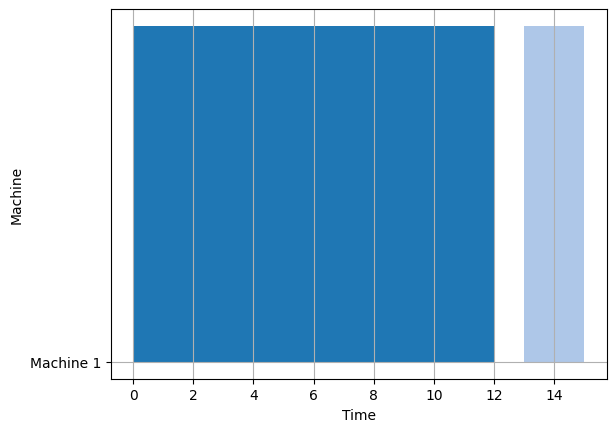

In [2]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define parameters
num_machines = 1
num_products = 2
random.seed(42)
MAX_TIME = 20
MAX_QUANTITY = 5
production_change_time = 1 # time needed when changing product

# Production times for each product on each machine
hours = {
    i : {j: random.randint(1, MAX_TIME) for j in range(num_machines)} for i in range(num_products)
}

# production quantities needed for each product
quantities = {i: random.randint(1, MAX_QUANTITY) for i in range(num_products)}
print(hours, quantities)

class status:
    def __init__(self, time, index, machine_status, cost, previous_status=None, raw_materials=None):
        self.time = time
        self.index = index
        self.machine_status = machine_status # i_product
        self.machine_available = [time]*len(machine_status) # time when machine is available
        self.cost = cost # cost of $ for producing the product at that time
        self.previous_status = previous_status
        self.raw_materials = raw_materials # is not considered in this problem
    
    def __lt__(self, other):
        return min(self.machine_status) < min(other.machine_status) or \
               (min(self.machine_status) == min(other.machine_status) and self.cost < other.cost)

# init dp
dp_shape = [quantities[product] + 1 for product in range(num_products)] + [num_machines]
dp = np.full(dp_shape, status(-1, [-1]*len(dp_shape), [-1]*num_machines, np.inf))

# init dp for time 0
for i in range(num_machines):
    dp[0, 0, i] = status(0, [0, 0, i], [0]*num_machines, 0)
for i in range(quantities[0] + 1):
    for j in range(quantities[1] + 1):
        for k in range(num_machines):
            if i == 0 and j == 0:
                continue
            previous_status = []
            for l in range(num_machines):
                time = 0
                if i > 0:
                    # install product 0 model on machine k
                    if dp[i-1,j,k].machine_status[k] != 0:
                        # add changing time
                        time += production_change_time
                    # add producing time for product 0
                    time += hours[0][k]
                    previous_status.append((time,dp[i-1,j,l]))
                time = 0
                if j > 0:
                    # install product 1 model on machine k
                    if dp[i,j-1,k].machine_status[k] != 1:
                        time += production_change_time
                    time += hours[1][k]
                    previous_status.append((time,dp[i,j-1,l]))
            previous_status = sorted(previous_status, key=lambda x: x[0])
            # new status:
            # produce product [index_diff] on machine k, 
                        # Determine new status
            for set in previous_status:
                s = set[1]
                # no resource constraint considered
                if True:
                    product_to_produce = np.array([i,j]) - np.array(s.index[:2])
                    index = np.argmax(product_to_produce)
                    dp[i, j, k] = status(s.time + set[0], [i, j, k], [index], s.cost + hours[index][k], previous_status=s)
                    break

print(dp[-1,-1,-1].cost)
# Extract the minimum production time
min_time = float('inf')
min_status = None
for k in range(num_machines):
    if dp[quantities[0], quantities[1], k] and dp[quantities[0], quantities[1], k].time < min_time:
        min_time = dp[quantities[0], quantities[1], k].time
        min_status = dp[quantities[0], quantities[1], k]

print(f"The minimum production time is: {min_time} hours")

# To find the schedule, we need to backtrack from min_status
schedule = []
current_status = min_status
while current_status is not None and current_status.previous_status is not None:
    schedule.append((current_status.index, current_status.time))
    current_status = current_status.previous_status

schedule.reverse()

print("Production schedule:")
for step in schedule:
    print(f"Produce product {step[0]} at time {step[1]}")

            
# for i in range(1, num_products): #XXX try to figure it out
#     for j in range(quantities[i] + 1):
#         for k in range(num_machines):
            
# Extract the minimum production time
min_time = float('inf')
min_status = None
for k in range(num_machines):
    if dp[tuple(quantities.values()) + (k,)] and dp[tuple(quantities.values()) + (k,)].time < min_time:
        min_time = dp[tuple(quantities.values()) + (k,)].time
        min_status = dp[tuple(quantities.values()) + (k,)]

print(f"The minimum production time is: {min_time} hours")

# To find the schedule, we need to backtrack from min_status
schedule = []
current_status = min_status
while current_status is not None and current_status.previous_status is not None:
    product_to_produce = np.array(current_status.index[:-1]) - np.array(current_status.previous_status.index[:-1])
    index = np.argmax(product_to_produce)
    schedule.append((index, current_status.time, current_status.index[-1]))
    current_status = current_status.previous_status

schedule.reverse()

print("Production schedule:")
for step in schedule:
    print(f"Produce product {step[0]} at time {step[1]} on machine {step[2]}")

# Generate Gantt chart
fig, gnt = plt.subplots()

# Setting labels for x-axis and y-axis
gnt.set_xlabel('Time')
gnt.set_ylabel('Machine')

# Setting ticks on y-axis
gnt.set_yticks([10 + i * 10 for i in range(num_machines)])
gnt.set_yticklabels([f'Machine {i+1}' for i in range(num_machines)])

# Setting graph attribute
gnt.grid(True)

# Adding Gantt chart bars
color_map = plt.get_cmap("tab20")
colors = [color_map(i) for i in range(num_products)]

for step in schedule:
    product_index = step[0]
    machine = step[2]
    time = step[1]
    duration = hours[product_index][machine]
    gnt.broken_barh([(time - duration, duration)], (10 + machine * 10, 9), facecolors=(colors[product_index]))

plt.show()



{0: {0: 5}, 1: {0: 8}}
{0: 2, 1: 2}
The minimum production time is: 13 hours
Production schedule:
Produce product 0 at time 0 on machine 0
Produce product 0 at time 5 on machine 0
Produce product 1 at time 9 on machine 0
Produce product 1 at time 13 on machine 0


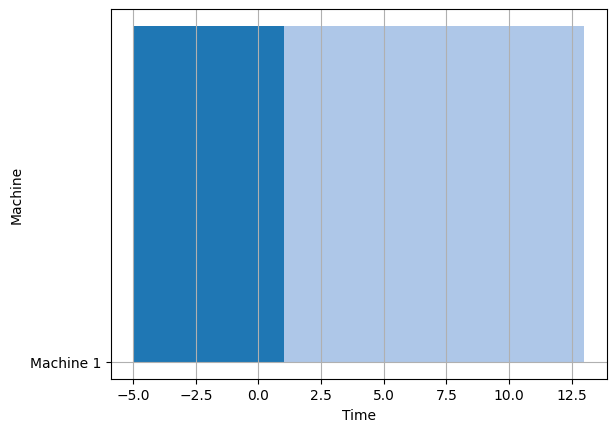

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define parameters
num_machines = 1
num_products = 2
random.seed(22)
MAX_TIME = 20
MAX_QUANTITY = 5
production_change_time = 1 # time needed when changing product

# Production times for each product on each machine
hours = {
    i: {j: random.randint(1, MAX_TIME) for j in range(num_machines)} for i in range(num_products)
}

# Production quantities needed for each product
# quantities = {i: random.randint(1, MAX_QUANTITY) for i in range(num_products)}
quantities = {i: 2 for i in range(num_products)}
print(hours)
print(quantities)

class Status:
    def __init__(self, time, index, machine_status, cost, previous_status=None, raw_materials=None):
        self.time = time
        self.index = index
        self.machine_status = machine_status # i_product
        self.machine_available = [0]*len(machine_status) # time when machine is available
        self.cost = cost # cost of $ for producing the product at that time
        self.previous_status = previous_status
        self.raw_materials = raw_materials # is not considered in this problem
    
    def __lt__(self, other):
        # return min(self.machine_status) < min(other.machine_status) or \
        #        (min(self.machine_status) == min(other.machine_status) and self.cost < other.cost)
        return self.time < other.time \
                or (self.time == other.time and min(self.machine_status) < min(other.machine_status))
    
    def __print__(self):
        # print(f"Time: {self.time}, Index: {self.index}, Machine status: {self.machine_status}, Cost: {self.cost}")
        print(self.index)

# Initialize dp array
dp_shape = [quantities[product] + 1 for product in range(num_products)] + [num_machines]
dp = np.full(dp_shape, None, dtype=object)

# Initialize dp for time 0
for k in range(num_machines):
    # dp[tuple([0] * num_products + [k])] = Status(0, [0] * (num_products + 1), [0] * num_machines, 0)
    dp[tuple([0] * num_products + [k])] = Status(0, [0] * (num_products)+[k], [-1] * num_machines, 0)

# Dynamic programming approach to fill dp table
for indices in np.ndindex(*dp_shape[:-1]):  # O(Q1*Q2*...*Qn)
    for k in range(num_machines):           # O(M)
        if all(i == 0 for i in indices):
            continue
        previous_status = []
        for l in range(num_machines):       # O(M)
            for i in range(len(indices)):   # O(n)
                if indices[i] > 0: # the quantity of product i is >0 we have to consider the previous status
                    time = 0    
                    p_status = dp[tuple(indices[:i] + (indices[i]-1,) + indices[i+1:] + (l,))] # previous status
                    if p_status.machine_status[k] != i:
                        time = production_change_time
                    time += hours[i][l]
                    previous_status.append((time, i, p_status))
        sorted(previous_status, key=lambda x: x[0])
        
        # Determine new status for each product
        for set in previous_status:
            s = set[2]
            # TODO: check resource constraints
            if True:
                product_to_produce = np.array(indices) - np.array(s.index[:-1])
                product = np.argmax(product_to_produce)
                time_needed = hours[product][k] + (production_change_time if k > 0 else 0)
                # if(dp[tuple(indices) + (k,)] is not None and dp[tuple(indices) + (k,)].time < previous_status[0].time + time_needed):
                #     continue
                t = set[0]+s.previous_status.time if s.previous_status is not None else 0
                new_status = Status(t, tuple(indices) + (k,), s.machine_status[:], s.cost, s)
                new_status.machine_available[k] = new_status.time
                new_status.machine_status[k] = product
                dp[tuple(indices) + (k,)] = new_status


# Extract the minimum production time
min_time = float('inf')
min_status = None
for k in range(num_machines):
    if dp[tuple(quantities.values()) + (k,)] and dp[tuple(quantities.values()) + (k,)].time < min_time:
        min_time = dp[tuple(quantities.values()) + (k,)].time
        min_status = dp[tuple(quantities.values()) + (k,)]

print(f"The minimum production time is: {min_time} hours")

# To find the schedule, we need to backtrack from min_status
schedule = []
current_status = min_status
while current_status is not None and current_status.previous_status is not None:
    product_to_produce = np.array(current_status.index[:-1]) - np.array(current_status.previous_status.index[:-1])
    index = np.argmax(product_to_produce)
    schedule.append((index, current_status.time, current_status.index[-1]))
    current_status = current_status.previous_status

schedule.reverse()

print("Production schedule:")
for step in schedule:
    product_index = step[0]
    print(f"Produce product {product_index} at time {step[1]} on machine {step[2]}")

# Generate Gantt chart
fig, gnt = plt.subplots()

# Setting labels for x-axis and y-axis
gnt.set_xlabel('Time')
gnt.set_ylabel('Machine')

# Setting ticks on y-axis
gnt.set_yticks([10 + i * 10 for i in range(num_machines)])
gnt.set_yticklabels([f'Machine {i+1}' for i in range(num_machines)])

# Setting graph attribute
gnt.grid(True)

# Adding Gantt chart bars
color_map = plt.get_cmap("tab20")
colors = [color_map(i) for i in range(num_products)]

for step in schedule:
    product_index = step[0]
    machine = step[2]
    time = step[1]
    duration = hours[product_index][machine]
    gnt.broken_barh([(time - duration, duration)], (10 + machine * 10, 9), facecolors=(colors[product_index]))

plt.show()


h = {0: {0: 5, 1: 8}, 1: {0: 1, 1: 20}}

q = {0: 2, 1: 2}

index         time  
(0,0,0)       0
(0,0,1)       0
(0,1,0) ===>  h[1][0]: 1    (0,0,0)
              h[1][0]: 1    (0,0,1)
(0,1,1) ===>  h[1][1]: 20   (0,0,0)
                            (0,0,1)
(1,0,0) ===>  h[0][0]: 5    (0,0,0)
                            (0,0,1)
(1,0,1) ===>  h[0][1]: 8    (0,0,0)
                            (0,0,1)
(1,1,0)                     (0,1,0)
                            (0,1,1)
                            (1,0,0)
                            (1,0,1)

(1,1,1)                     (0,1,0)
                            (0,1,1)
                            (1,0,0)
                            (1,0,1)

(1,2,0)                     (0,2,0)
                            (0,2,1)
                            (1,1,0)
                            (1,1,1)

(1,2,1)                     (0,2,0)
                            (0,2,1)
                            (1,1,0)
                            (1,1,1)

(2,2,0)                     (1,2,0)
                            (1,2,1)
                            (2,1,0)
                            (2,1,1)

(2,2,1)                     (1,2,0)
                            (1,2,1)
                            (2,1,0)
                            (2,1,1)

# M Factory is useless ?
## NO, $(1,2,0)$ is not the same as $(1,2,1)$!

In [5]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Define parameters
num_machines = 2
num_products = 2
random.seed(22)
MAX_TIME = 20
MAX_QUANTITY = 5
production_change_time = 0 # time needed when changing product

# Production times for each product on each machine
hours = {
    i: {j: random.randint(1, MAX_TIME) for j in range(num_machines)} for i in range(num_products)
}

# Production quantities needed for each product
# quantities = {i: random.randint(1, MAX_QUANTITY) for i in range(num_products)}
quantities = {i: 2 for i in range(num_products)}
print(hours)
print(quantities)

class Status:
    def __init__(self, time, index, machine_status, cost, previous_status=None, raw_materials=None):
        self.time = time
        self.index = index
        self.machine_status = machine_status # i_product
        self.machine_available = [0]*len(machine_status) # time when machine is available
        self.cost = cost # cost of $ for producing the product at that time
        self.previous_status = previous_status
        self.raw_materials = raw_materials # is not considered in this problem
    
    def __lt__(self, other):
        # return min(self.machine_status) < min(other.machine_status) or \
        #        (min(self.machine_status) == min(other.machine_status) and self.cost < other.cost)
        return self.time < other.time \
                or (self.time == other.time and min(self.machine_status) < min(other.machine_status))

# Initialize dp array
dp_shape = [quantities[product] + 1 for product in range(num_products)]
dp = np.full(dp_shape, None, dtype=object)

# Initialize dp for time 0
dp[tuple([0] * num_products)] = Status(0, [0] * (num_products)+[-1], [0] * num_machines, 0)

# Dynamic programming approach to fill dp table
for indices in np.ndindex(*dp_shape[:-1]):  # O(Q1*Q2*...*Qn)
    if all(i == 0 for i in indices):
        continue
    previous_status = []
    for l in range(num_machines):       # O(M)
        for i in range(len(indices)):   # O(n)
            if indices[i] > 0: # the quantity of product i is >0 we have to consider the previous status
                previous_indices = list(indices)[i] - 1 # check (i-1)th product
                p_status = dp[tuple(previous_indices + (l,))]
                
    #             p_status = dp[tuple(indices[:i] + (indices[i]-1,) + indices[i+1:])] # previous status
    #             if p_status.machine_status[k] != i:
    #                 time = production_change_time
    #             time += hours[i][k]
    #             previous_status.append((time, i, p_status))
    # sorted(previous_status, key=lambda x: x[0])

    # # Determine new status for each product
    # for set in previous_status:
    #     s = set[2]

{0: {0: 5, 1: 8}, 1: {0: 1, 1: 20}}
{0: 2, 1: 2}
